# OpenStreetMap 結合 Python，如何找到你想要的資料

### 常用的 Python 套件與方法
slide: https://github.com/Supaplextw/COSCUP-2020/blob/master/Python-OSM-COSCUP-2020.ipynb
<div style="text-align: right;">OpenStreetMap台灣 - 陳瑞霖</div>

# OpenStreetMap
* 地圖版的維基百科
* 在臺灣社群發展十年
* 自己的地圖自己畫
* tag 系統有彈性，能照顧少數需求
* 例：第三世界防災，台語地圖

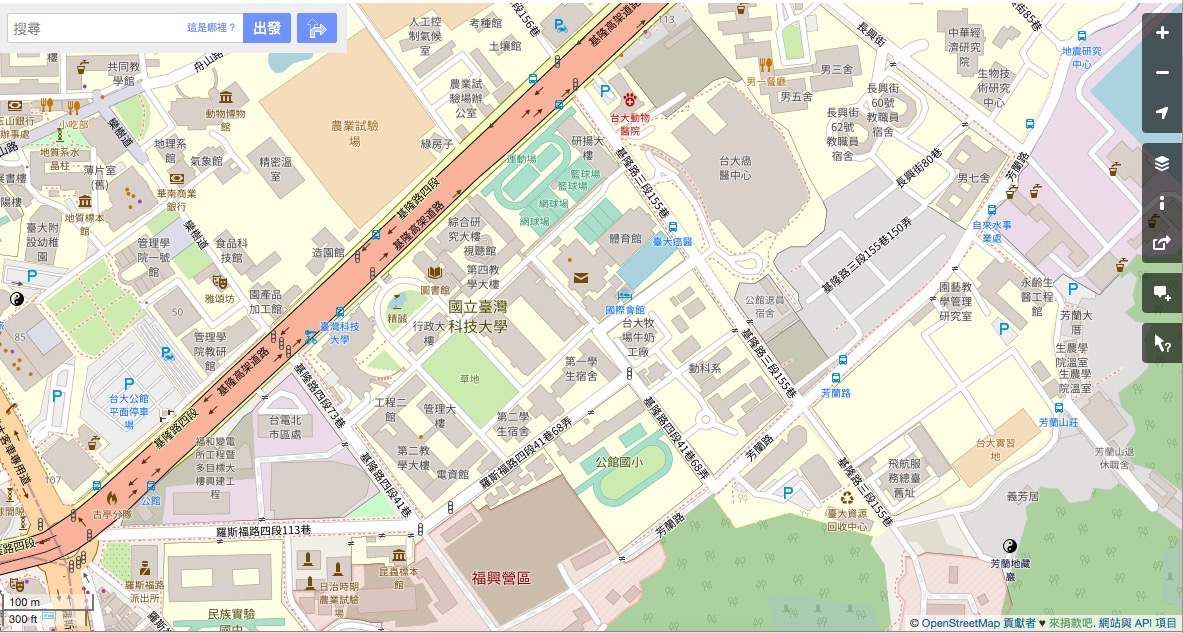

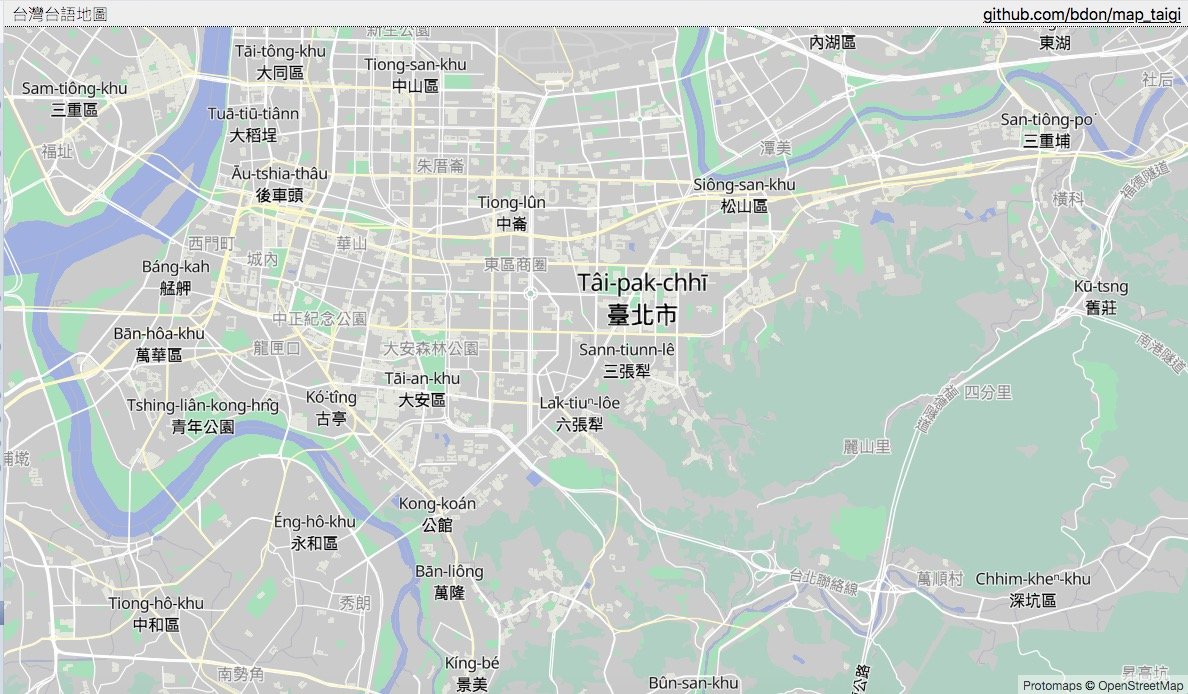

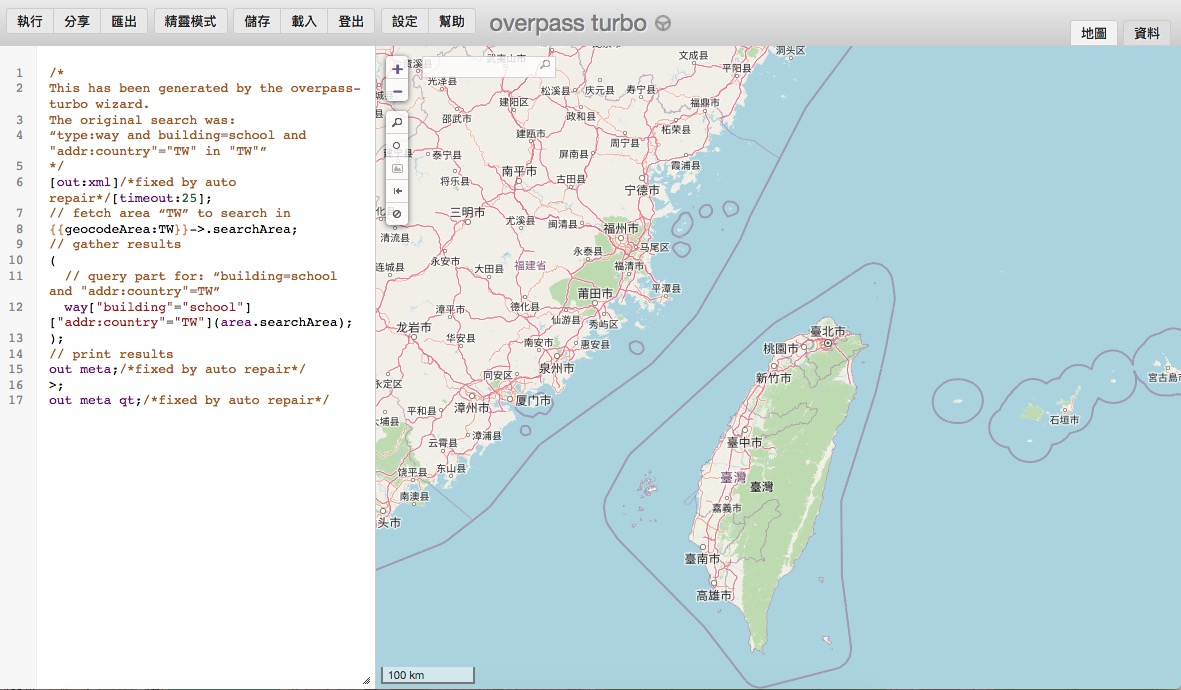

## 運用套件和資料
* 直接用常用的網路套件：requests、json
* Overpass API
* 專用基礎套件：OSMPythonTools
* 進階套件：OSMnx
* 地圖呈現套件：folium

## requests、json
* 簡單，只要有架設網路相關套件就能取用 OpenStreetMap
* 難度，需要有基本的網頁知識與 API 概念

## OpenStreetMap 的 API
* OpenStreetMap API
* Overpass API
* 其他第三方 API，例如 Mapbox、Mapillary

In [1]:
import requests
import json


In [2]:
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
[out:json];
area["nat_ref"="63"][admin_level=4];
(node["amenity"="restaurant"](area);
 way["amenity"="restaurant"](area);
 rel["amenity"="restaurant"](area);
);
out center;
"""

In [3]:
response = requests.get(overpass_url, 
                        params={'data': overpass_query})
data = response.json()

In [4]:
import numpy as np
import matplotlib.pyplot as plt # 輸出圖表用

# Collect coords into list
coords = []
for element in data['elements']:
  if element['type'] == 'node':
    lon = element['lon']
    lat = element['lat']
    coords.append((lon, lat))
  elif 'center' in element:
    lon = element['center']['lon']
    lat = element['center']['lat']
    coords.append((lon, lat))

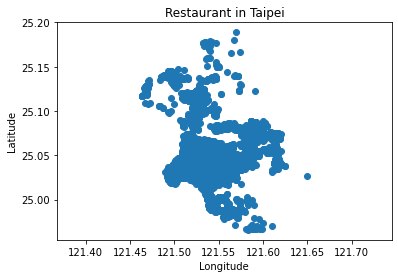

In [5]:
# Convert coordinates into numpy array
X = np.array(coords)

plt.plot(X[:, 0], X[:, 1], 'o')
plt.title('Restaurant in Taipei')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('equal')
plt.show()

Overpass Turbo 範例：臺北市的餐廳
https://overpass-turbo.eu/s/WDS

匯出存檔為 geojson 檔案，直接取得 GeoPandas 能處理的格式

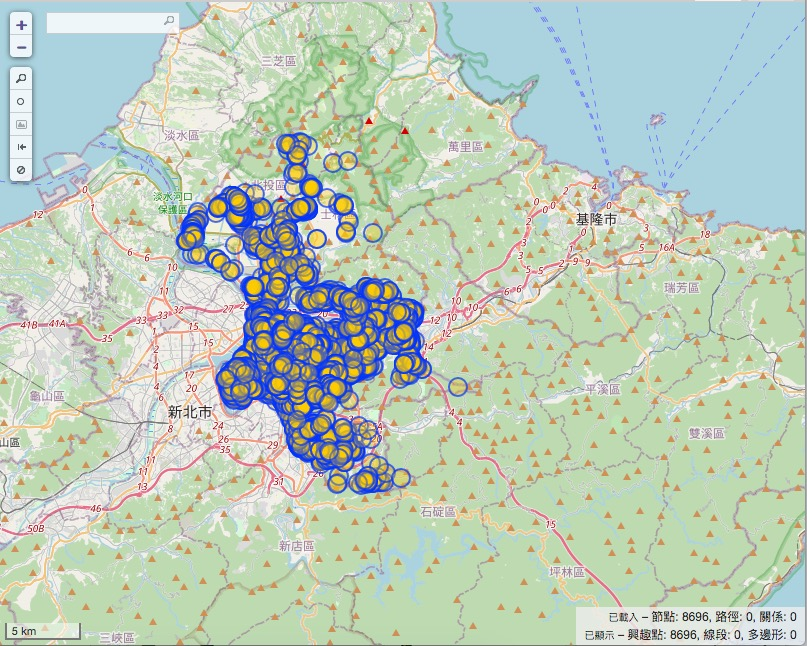

In [6]:
import geopandas as gpd
gdf = gpd.read_file("restaurant-tpe.geojson")
gdf.head()

id             @id addr:city addr:country addr:district  \
0  node/283374380  node/283374380       台北市           TW           士林區   
1  node/299002404  node/299002404      None         None          None   
2  node/469812996  node/469812996       臺北市           TW           中正區   
3  node/569950080  node/569950080      None         None          None   
4  node/569950081  node/569950081      None         None          None   

  addr:housenumber addr:postcode addr:street     amenity      cuisine  ...  \
0                5           111        德行西路  restaurant       german  ...   
1             None          None        None  restaurant     american  ...   
2              129         10045      重慶南路一段  restaurant  steak_house  ...   
3             None          None        None  restaurant         None  ...   
4             None          None        None  restaurant    breakfast  ...   

  branch:zh-Hant delivery:ubereats old_name:en old_name:nan old_name:zh  \
0           None              None        None         None        None   
1           None              None        None         None        None   
2           None              None        None         None        None   
3           None              None        None         None        None   
4           None              None        None         None        None   

  checkout  vegetarian  payment:LINE_Pay payment:visa_debit  \
0     None        None              None               None   
1     None        None              None               None   
2     None        None              None               None   
3     None        None              None               None   
4     None        None              None               None   

                     geometry  
0  POINT (121.52407 25.10639)  
1  POINT (121.56870 25.03218)  
2  POINT (121.51329 25.04205)  
3  POINT (121.56903 25.02583)  
4  POINT (121.56918 25.02465)  

[5 rows x 208 columns]

In [7]:
# Select some useful cols and print
cols = ['name', 'name:en', 'cuisine', 'addr:street', 'takeaway', 'delivery']
# Print only selected cols
gdf[cols].head(10)

name                     name:en      cuisine  \
0                温德德式烘焙餐館  Wendel's bakery and bistro       german   
1         N.Y.Bagels Cafe                        None     american   
2                      西堤                       TASTy  steak_house   
3                 various                        None         None   
4                   上品早餐坊                        None    breakfast   
5             Schwarzwald                        None       german   
6               Honey Pig                        None       korean   
7               台科大第一學生餐廳                        None         None   
8  3 Idiots toast & curry                        None        pizza   
9                    希臘佐巴                    Greek Go         None   

  addr:street takeaway delivery  
0        德行西路     None     None  
1        None     None     None  
2      重慶南路一段     None       no  
3        None     None     None  
4        None     None     None  
5        None     None     None  
6       信義路四段     None     None  
7        None     None     None  
8  羅斯福路三段283巷     None     None  
9        None     None     None

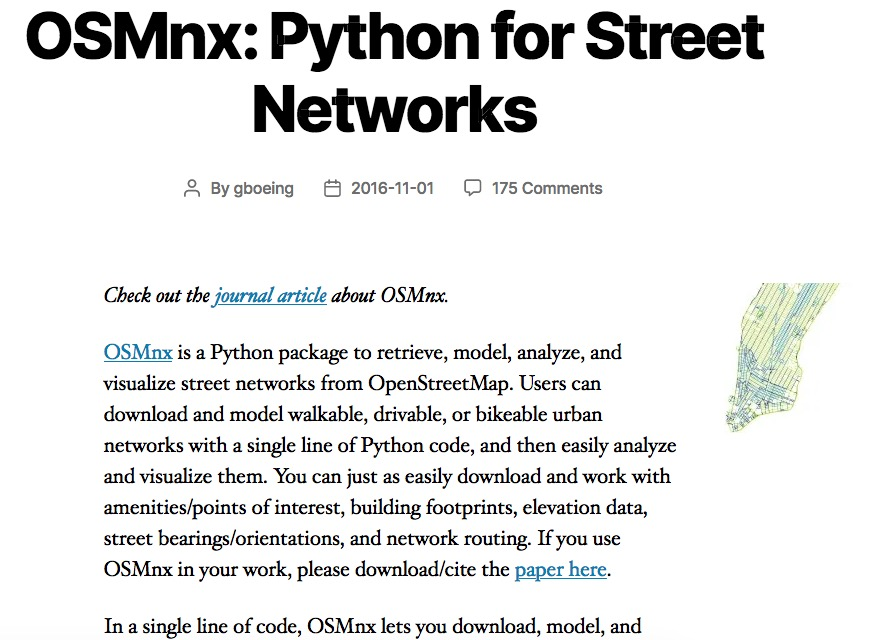

In [8]:
import osmnx as ox
import matplotlib.pyplot as plt 
%matplotlib inline

ox.config(log_console=True, use_cache=True)
ox.__version__

'0.11.4'

In [9]:
place = "Daan District, Taipei City, Taiwan"
G = ox.graph_from_place(place)

In [10]:
ox.stats.basic_stats(G, area=None, clean_intersects=False, tolerance=15, circuity_dist='gc')
# 傳回基本的統計資訊

{'n': 6438,
 'm': 17046,
 'k_avg': 5.295433364398882,
 'intersection_count': 5951,
 'streets_per_node_avg': 3.282075178626903,
 'streets_per_node_counts': {0: 0,
  1: 487,
  2: 11,
  3: 3186,
  4: 2711,
  5: 39,
  6: 4},
 'streets_per_node_proportion': {0: 0.0,
  1: 0.07564461012736874,
  2: 0.001708605156881019,
  3: 0.49487418452935694,
  4: 0.42109350730040385,
  5: 0.0060577819198508855,
  6: 0.0006213109661385523},
 'edge_length_total': 714634.3640000023,
 'edge_length_avg': 41.923874457350834,
 'street_length_total': 455838.8509999996,
 'street_length_avg': 43.62511733180205,
 'street_segments_count': 10449,
 'node_density_km': None,
 'intersection_density_km': None,
 'edge_density_km': None,
 'street_density_km': None,
 'circuity_avg': 1.0274424121206702,
 'self_loop_proportion': 0.0006453126833274669,
 'clean_intersection_count': None,
 'clean_intersection_density_km': None}

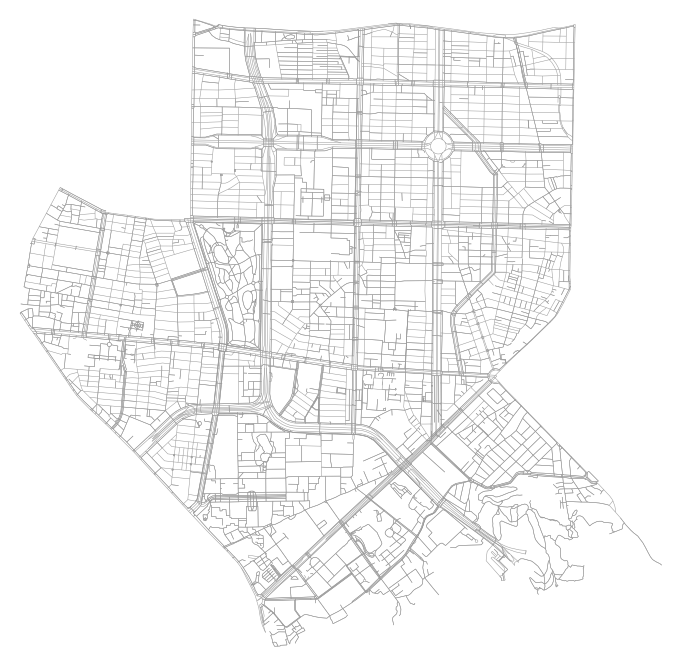

In [11]:
fig, ax = ox.plot_graph(G, fig_height=12, node_size=0, edge_linewidth=0.5)
# 傳回大安區範圍內的道路網

In [12]:
area = ox.gdf_from_place(place)
# 轉換 place 變成 GeoPandas 能處理的類型

In [13]:
type(area)
# 發現 area 是屬於 GeoPandas 的 GeoDataFrame 類型物件

geopandas.geodataframe.GeoDataFrame

In [14]:
area
# 傳回大安區的最東、西、南、北的邊界

geometry  \
0  POLYGON ((121.52172 25.02808, 121.52239 25.027...   

                       place_name  bbox_north  bbox_south   bbox_east  \
0  Da'an District, Taipei, Taiwan   25.045448   25.007217  121.565879   

    bbox_west  
0  121.521722

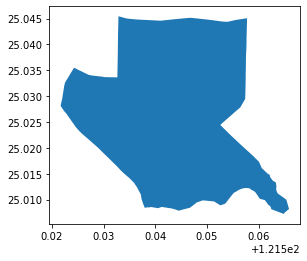

In [15]:
area.plot()
# 用 Matplotlib 畫出臺北市的範圍

In [16]:
area['geometry']
# 傳回臺北市的 geometry 數值，以及前幾筆構成 polygram 的點經緯度

0    POLYGON ((121.52172 25.02808, 121.52239 25.027...
Name: geometry, dtype: geometry

In [17]:
buildings = ox.footprints_from_place(place)

In [18]:
len(buildings)
# 回傳建築物數量

6644

In [19]:
buildings.head(3)
# 傳回前三筆建築資料，先大略看資料的情形

nodes     building  \
39205564  [469626931, 469626932, 469626933, 473438463, 4...   university   
39219790  [469825010, 469825020, 469825025, 469825031, 4...  residential   
39240218  [470117931, 470117932, 470117933, 470117935, 6...          yes   

           name                                            name:en  \
39205564    原分所  Institute of Atomic and Molecular Sciences, Ac...   
39219790    NaN                                                NaN   
39240218  綜合體育館                                  NTU Sports Center   

                                             name:zh_pinyin   office_name:zh  \
39205564  Zhōngyāng Yánjiùyuàn yuánzǐ yǔ fēnzǐ kēxué yán...  中央研究院原子與分子科學研究所   
39219790                                                NaN              NaN   
39240218                 Guólì Táiwān dàxúe zōnghé tǐyùguǎn              NaN   

            official_name postal_code  \
39205564  中央研究院原子與分子科學研究所       10617   
39219790              NaN         NaN   
39240218              NaN         NaN   

                                                   geometry building:levels  \
39205564  POLYGON ((121.53775 25.01881, 121.53883 25.018...             NaN   
39219790  POLYGON ((121.53392 25.02123, 121.53401 25.021...               7   
39240218  POLYGON ((121.53476 25.02125, 121.53489 25.021...              12   

          ... network building:min_level  fee name:nan landuse covered  \
39205564  ...     NaN                NaN  NaN      NaN     NaN     NaN   
39219790  ...     NaN                NaN  NaN      NaN     NaN     NaN   
39240218  ...     NaN                NaN  NaN      NaN     NaN     NaN   

         air_conditioning addr:village members type  
39205564              NaN          NaN     NaN  NaN  
39219790              NaN          NaN     NaN  NaN  
39240218              NaN          NaN     NaN  NaN  

[3 rows x 169 columns]

In [20]:
buildings.columns
# 觀察 OpenStreetMap 資料當中，建築物有那些欄位

Index(['nodes', 'building', 'name', 'name:en', 'name:zh_pinyin',
       'office_name:zh', 'official_name', 'postal_code', 'geometry',
       'building:levels',
       ...
       'network', 'building:min_level', 'fee', 'name:nan', 'landuse',
       'covered', 'air_conditioning', 'addr:village', 'members', 'type'],
      dtype='object', length=169)

In [21]:
# 截取餐聽
restaurants = ox.pois_from_place(place, amenities=['restaurant'])

# 大安區有幾間餐廳?
len(restaurants)

1203

In [22]:
# 有那些欄位
restaurants.columns

Index(['osmid', 'geometry', 'addr:city', 'addr:country', 'addr:district',
       'addr:housenumber', 'addr:postcode', 'addr:street', 'amenity',
       'cuisine',
       ...
       'branch:en', 'description:branch', 'self_service', 'microbrewery',
       'payment:LINE_Pay', 'payment:visa_debit', 'nodes', 'building', 'ref:zh',
       'building:levels'],
      dtype='object', length=122)

In [23]:
# 選擇你感興趣特定的欄位
cols = ['name', 'name:en', 'cuisine', 'addr:street', 'takeaway', 'delivery']
# 只顯示特定欄位
restaurants[cols].head(10)

name    name:en      cuisine addr:street takeaway  \
738612589          台科大第一學生餐廳        NaN          NaN         NaN      NaN   
743174782               希臘佐巴   Greek Go          NaN         NaN      NaN   
924214891           小蔬杭 絕對蔬食        NaN          NaN      羅斯福路四段      yes   
1081855284            濟南路水煎包        NaN          NaN         NaN      NaN   
1281234333             Diary        NaN          NaN         東豐街      NaN   
1716390586              早安你好        NaN          NaN         浦城街      NaN   
1850962941              春天素食        NaN          NaN      和平東路一段      NaN   
1924425158  N.Y. Bagels Cafe        NaN     american         NaN      NaN   
1947348386                圍爐        NaN      chinese         NaN      NaN   
1947370956              雅室牛排  Steak Inn  steak_house         NaN      NaN   

           delivery  
738612589       NaN  
743174782       NaN  
924214891       NaN  
1081855284      NaN  
1281234333      NaN  
1716390586      NaN  
1850962941      NaN  
1924425158      NaN  
1947348386      NaN  
1947370956      NaN

## osmnx
* 強項為路網分析
* networkx 衍生的套件

In [24]:
# 截取道路網的線條和交叉點
nodes, edges = ox.graph_to_gdfs(G)

In [25]:
nodes.head()
# 路網當中的交叉點資訊

y           x       osmid highway  ref  \
4069900289  25.012132  121.536727  4069900289     NaN  NaN   
4069900290  25.012101  121.536861  4069900290     NaN  NaN   
4069900293  25.012137  121.536841  4069900293     NaN  NaN   
4069900298  25.012250  121.536980  4069900298     NaN  NaN   
4069900301  25.013259  121.539366  4069900301     NaN  NaN   

                              geometry  
4069900289  POINT (121.53673 25.01213)  
4069900290  POINT (121.53686 25.01210)  
4069900293  POINT (121.53684 25.01214)  
4069900298  POINT (121.53698 25.01225)  
4069900301  POINT (121.53937 25.01326)

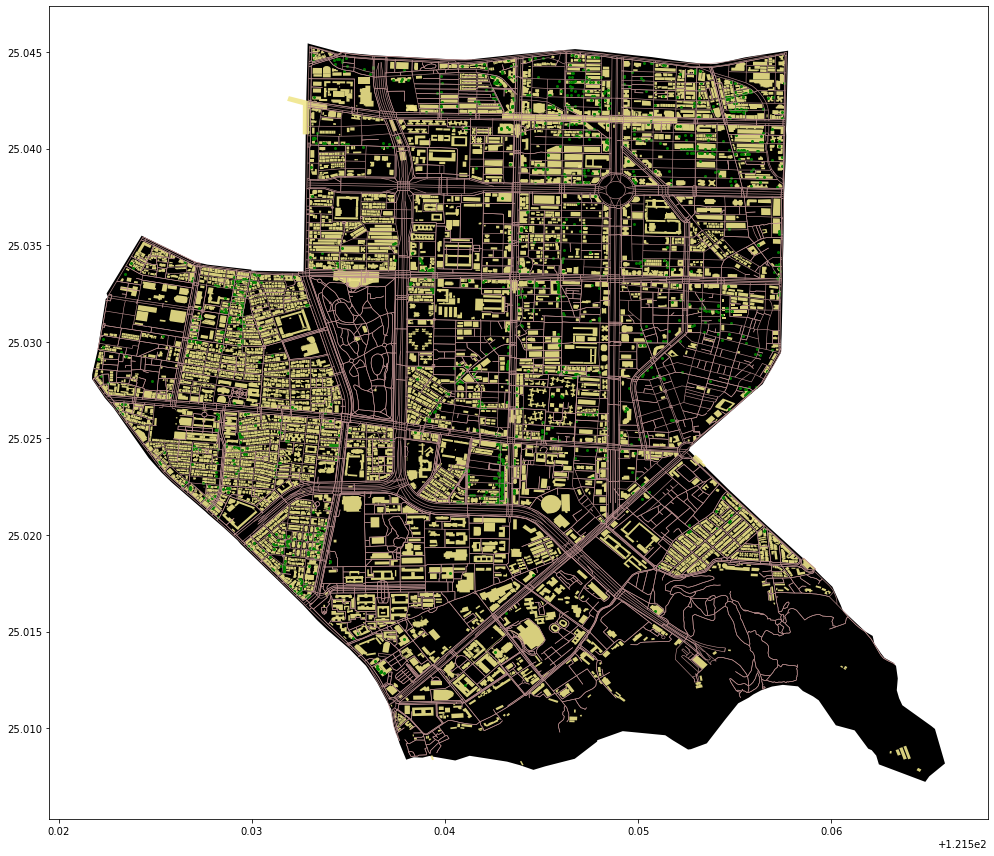

In [26]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(18,12))

# Plot the footprint
area.plot(ax=ax, facecolor='black')

# Plot street edges
edges.plot(ax=ax, linewidth=0.6, edgecolor='#BC8F8F')

# Plot buildings
buildings.plot(ax=ax, facecolor='khaki', alpha=0.9)

# Plot restaurants
restaurants.plot(ax=ax, color='green', alpha=0.9, markersize=4)
plt.tight_layout()

In [27]:
from pyproj import CRS

# Set projection
projection = CRS.from_epsg(3826) #TWD97 投影

# Re-project layers
area2 = area.to_crs(projection)
edges2 = edges.to_crs(projection)
buildings2 = buildings.to_crs(projection)
restaurants2 = restaurants.to_crs(projection)

# 轉換座標系統，變成 TWD97

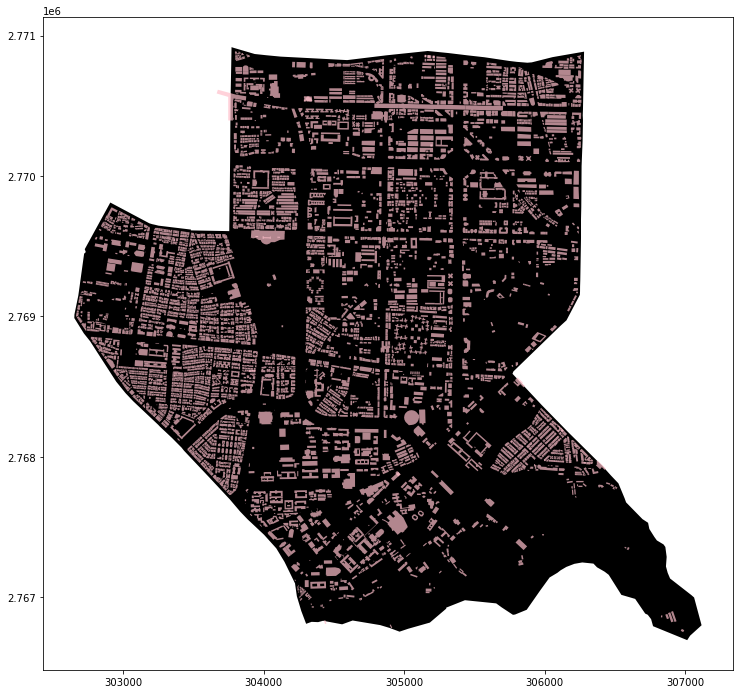

In [28]:
fig, ax = plt.subplots(figsize=(18,12))

# Plot the footprint
area2.plot(ax=ax, facecolor='black')

# Plot buildings
buildings2.plot(ax=ax, facecolor='pink', alpha=0.7)

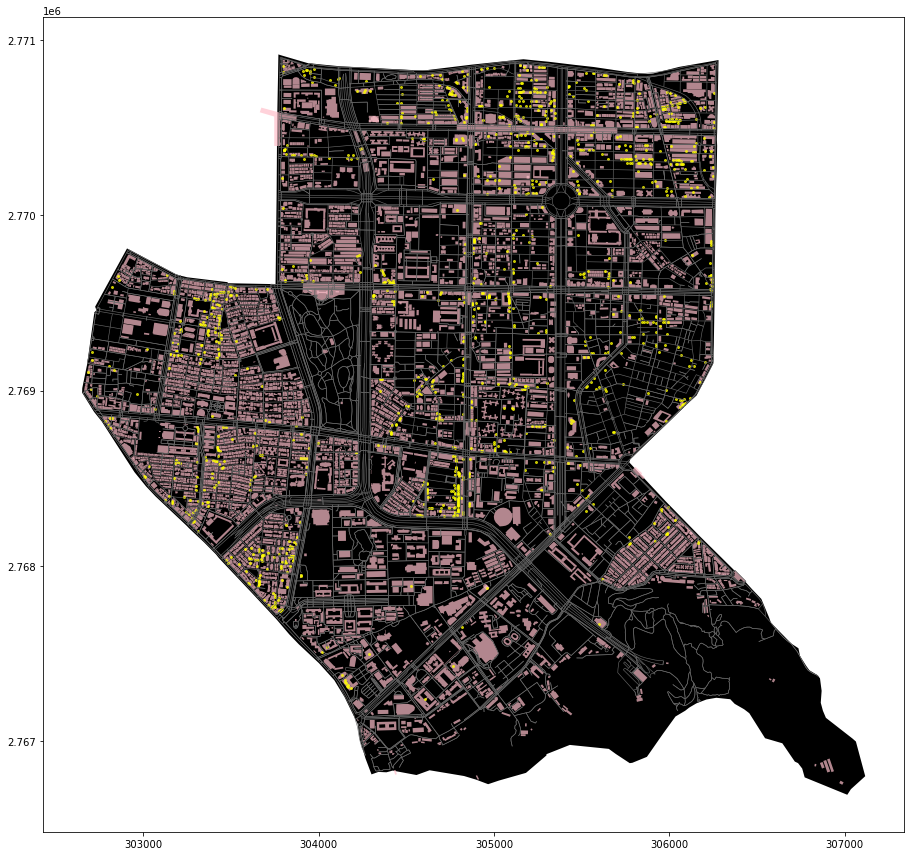

In [29]:
fig, ax = plt.subplots(figsize=(18,12))

# Plot the footprint
area2.plot(ax=ax, facecolor='black')

# Plot street edges
edges2.plot(ax=ax, linewidth=0.6, edgecolor='dimgray')

# Plot buildings
buildings2.plot(ax=ax, facecolor='pink', alpha=0.7)

# Plot restaurants
restaurants2.plot(ax=ax, color='yellow', alpha=0.7, markersize=4)
plt.tight_layout()

# Wikidata 上的 OpenStreetMap 資料
* 幫忙打 Wikidata 廣告
* 介紹 Wikidata Query Service
* 也可以用 Python 來截取資料


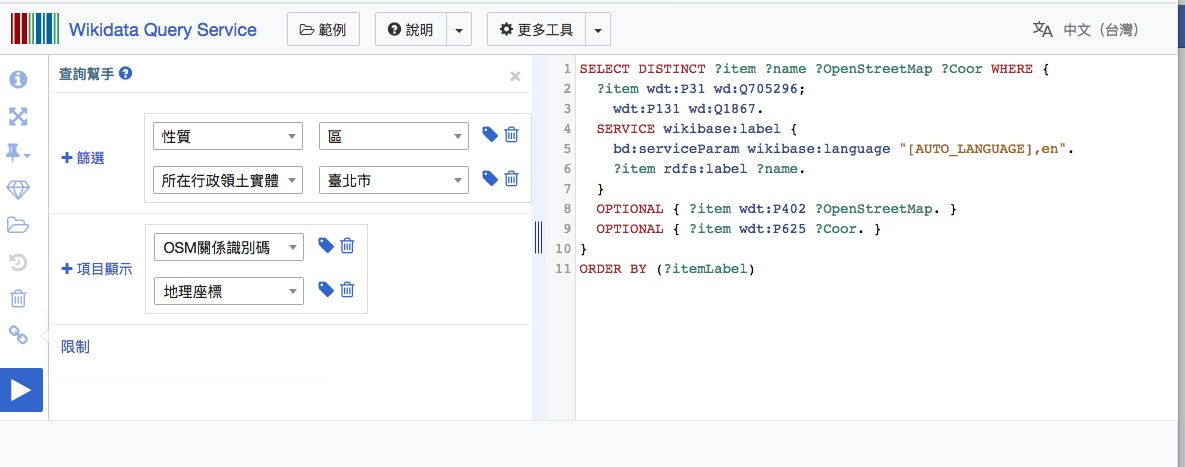
https://w.wiki/YPC

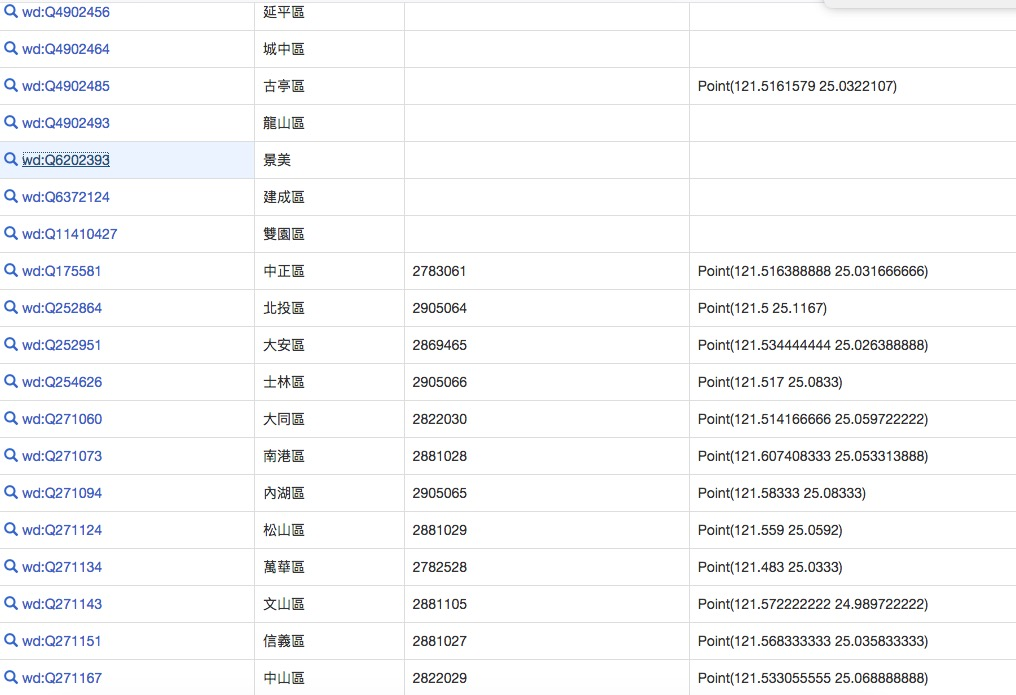

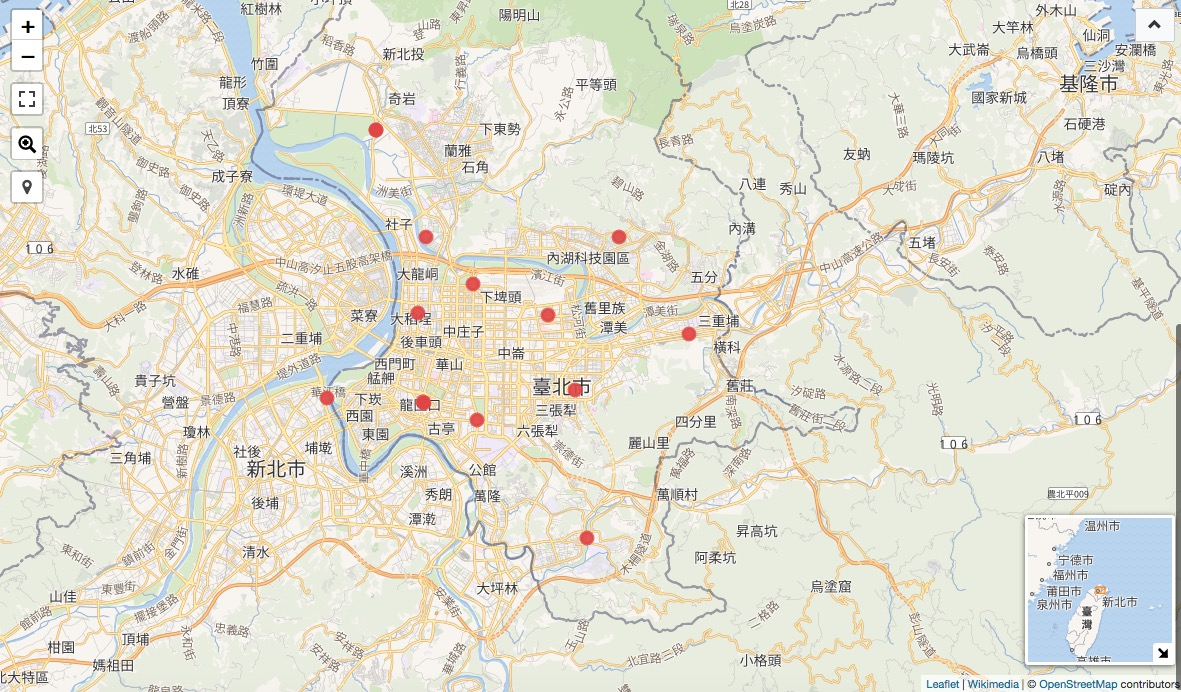

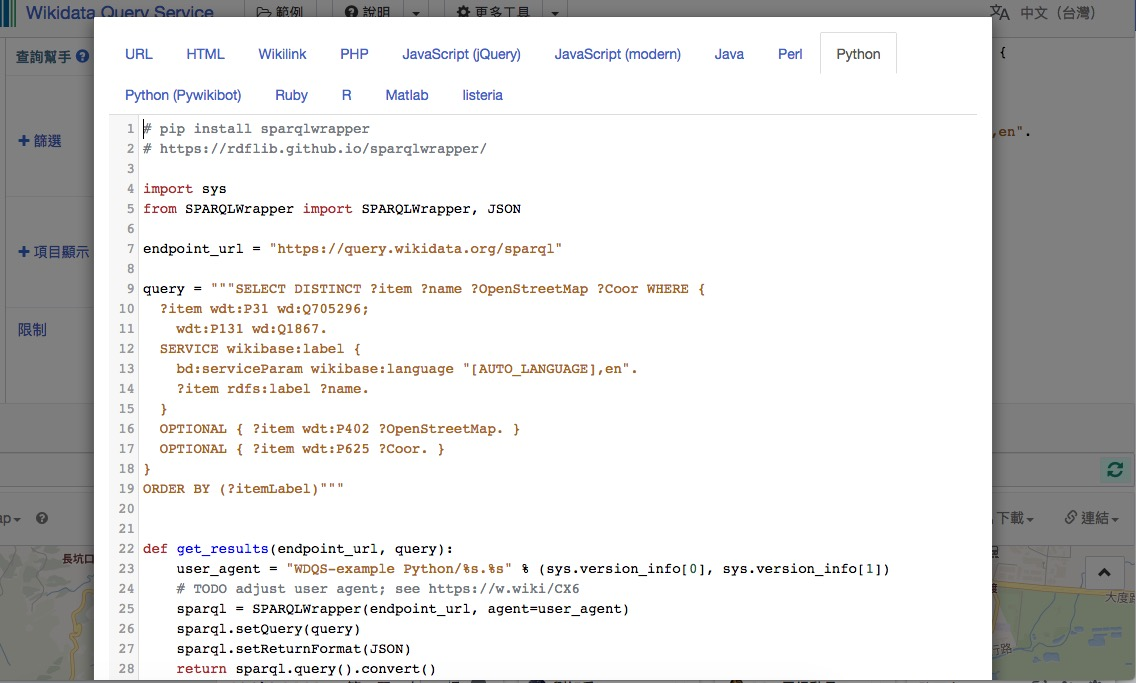

In [31]:
# pip install sparqlwrapper
# https://rdflib.github.io/sparqlwrapper/

import sys
from SPARQLWrapper import SPARQLWrapper, JSON

endpoint_url = "https://query.wikidata.org/sparql"

query = """SELECT DISTINCT ?item ?name ?Hu ?OpenStreetMap ?Coor WHERE {
  ?item wdt:P31 wd:Q705296;
    wdt:P131 wd:Q1867.
  SERVICE wikibase:label {
    bd:serviceParam wikibase:language "[AUTO_LANGUAGE],zh".
    ?item rdfs:label ?name.
  }
  OPTIONAL { ?item wdt:P5020 ?Hu. }
  OPTIONAL { ?item wdt:P402 ?OpenStreetMap. }
  OPTIONAL { ?item wdt:P625 ?Coor. }
}
ORDER BY (?itemLabel)"""


def get_results(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s" % (sys.version_info[0], sys.version_info[1])
    # TODO adjust user agent; see https://w.wiki/CX6
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()


results = get_results(endpoint_url, query)

for result in results["results"]["bindings"]:
    print(result)


{'item': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q4902456'}, 'name': {'xml:lang': 'zh', 'type': 'literal', 'value': '延平區'}}
{'item': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q4902464'}, 'name': {'xml:lang': 'zh', 'type': 'literal', 'value': '城中區'}}
{'item': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q4902485'}, 'name': {'xml:lang': 'zh', 'type': 'literal', 'value': '古亭區'}, 'Coor': {'datatype': 'http://www.opengis.net/ont/geosparql#wktLiteral', 'type': 'literal', 'value': 'Point(121.5161579 25.0322107)'}}
{'item': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q4902493'}, 'name': {'xml:lang': 'zh', 'type': 'literal', 'value': '龍山區'}}
{'item': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q6202393'}, 'name': {'xml:lang': 'zh', 'type': 'literal', 'value': '景美'}}
{'item': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q6372124'}, 'name': {'xml:lang': 'zh', 'type': 'literal', 'value': '建成區'}}
{'item': {'type': 'ur

Python 的地圖套件：
* IPython.display
* Folium

In [7]:
%matplotlib inline
import ogr
import shapely
from shapely.geometry import *
import geopandas as gpd
import matplotlib.pyplot as plt
import IPython.display as display

osm = """
<iframe width="500" height="400" frameborder="0" scrolling="no" marginheight="0" marginwidth="0" \
src="http://www.openstreetmap.org/export/embed.html?bbox=121.5391%2C25.0175%2C121.5489%2C25.0106&amp;layer=mapnik" \
style="border: 1px solid black"></iframe><br/><small><a \
href="http://www.openstreetmap.org/#map=17/25.01392/121.54314">View Larger Map</a></small>
"""
display.HTML(osm)


In [4]:
import folium

m = folium.Map(location=[25.04297, 121.55711], zoom_start = 17)
m

In [5]:
folium.Marker(location=[25.04297, 121.55711], popup="PyData",tooltip="Click").add_to(m)
m

In [6]:
folium.Marker(location=[25.04297, 121.55711], popup="Youreator",tooltip="Click").add_to(m)
m

In [46]:
m.save('index.html')

# 謝謝大家

QA

下次 OpenStreetMap x Wikidata 月聚：8/10

# 參考資料

Reveal.js
* [Reveal.js](https://revealjs.com/)

Overpass API
* https://towardsdatascience.com/loading-data-from-openstreetmap-with-python-and-the-overpass-api-513882a27fd0

OSMnx:
* [OSMnx Example](https://github.com/gboeing/osmnx-examples/blob/master/notebooks)：[路網分析](https://github.com/gboeing/osmnx-examples/blob/master/notebooks/06-example-osmnx-networkx.ipynb)
* [赫爾辛基大學 Geo-Python-AutoGIS 課程-Retrieving OpenStreetMap data](https://automating-gis-processes.github.io/2017/lessons/L7/retrieve-osm-data.html)
* [OSMnx 說明文件](https://osmnx.readthedocs.io/en/stable/osmnx.html)
* [Day20 OSMnx應用 ](https://ithelp.ithome.com.tw/articles/10207981?sc=iThelpR)

IPython:
* http://darribas.org/gds15/content/labs/lab_03.html
* https://automating-gis-processes.github.io/site/notebooks/L5/interactive-map-folium.html

Folium:
* https://www.youtube.com/watch?v=QpBmO35pmVE
* https://github.com/tsaisunghao/Geography/blob/master/EarthquakeMap/geomapping.ipynb
* https://github.com/victorgau/wzu20180122/blob/master/%E5%9C%B0%E5%9C%96%E7%AF%84%E4%BE%8B/%E7%94%A8%20folium%20%E7%95%AB%E5%9C%B0%E5%9C%96.ipynb
* https://github.com/gotoariel/folium-demo/blob/master/demo/demo.ipynb